<center>
## Открытый курс по машинному обучению. Сессия № 3

### <center> Автор материала: Кирилл Трубанёв 

## <center> Индивидуальный проект по анализу данных "Modulbank AI Hack MSK" </center>

**Задача бинарной классификации**: по имеющимся обезличенным данным о клиентах банка спрогнозировать подключение клиентом услуги «ИКС».

Оригинал задачи https://boosters.pro/champ_modulbank_msk

Отборочный онлайн этап 20.03.2018 – 17.04.2018

**Рейтинг** строится на 30% тестового датасета, финальный рейтинг будет построен на 70% тестового датасета и может отличаться.

На момент взятия задачи публичный рейтинг был ... <img src='../../img/Rating_public.jpg' width=50%>


... финальный рейтинг был ... <img src='../../img/Rating_final.jpg' width=50%>

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ данных
 - Первичный визуальный анализ данных 
 - Инсайты, найденные зависимости
 - Выбор метрики
 - Выбор модели
 - Предобработка данных
 - Кросс-валидация и настройка гиперпараметров модели
 - Создание новых признаков и описание этого процесса
 - Построение кривых валидации и обучения 
 - Прогноз для тестовой или отложенной выборки
 - Выводы 
 
 Более детальное описание [тут](https://goo.gl/cJbw7V).

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import os.path
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, validation_curve
import xgboost as xgb
from sklearn.metrics import roc_auc_score

In [2]:
RANDOM_SEED = 17

In [3]:
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 20)

###  Часть 1. Описание набора данных и признаков

Датасет из соревнования Modulbank, где почти всё описание помещается в одну фразу "<font color='grey'>*по обезличенным данным о клиентах банка нужно спрогнозировать подключение клиентом услуги «ИКС»*</font>". Поэтому описать процесс сбора данных, решаемую задачу, её ценность, целевой и прочие признаки достоверно не возможно.

НО, по опыту банковских проектов и понимая, что это не продакш-задача, а учебная задача хакатона чтобы отселектить толковых сайнтистов для последующего хантинга в банк, стОит выдвинуть догадки о данных и признаках:
- Собирали данные о клиентах банка, подключивших или не подключивших услугу "ИКС"
- Услуга "ИКС" - это какой-то банковский продукт/сервис, который генерирует банку доход, но и требует расхода на его продажу. Поэтому, как минимум, имеет смысл как можно точнее понимать вероятность приобретения услуги чтобы наиболее эффективно продвигать эту услугу
- Целевой признак - бинарный факт подключения услуги "ИКС"
- Признаки - это какие-то характеристики клиента, причём пока непонятно, связанные или не связанные с целевым признаком (вот и посмотрим)
- Данные обезличенные - то есть о физическом смысле признаков, и тем более о том, что за клиенты, предстоит только догадываться 
- Одна строка данных - это один клиент. При этом хочется предполагать, что один клиент не встречается в данных несколько раз с разными описывающими признаками и/или с разным значением целевого признака
- Данные напрямую не явлются временным рядом (но при этом не обязательно на данных нельзя ввести отношение порядка по какой-то функции от подмножества признаков)
- Наверняка будут всякие учебные приколы с кривыми форматами данных, выбросами, пропусками, зашумливанием, силовым переопределением таргета для каких-то наблюдений, разными распределениями трейна и теста и прочими гениальными идеями организаторов как бы нагенерить побольше способов отделять более толковых сайнтистов от менее бестолковых 

Авторы пишут нам, что "<font color='grey'>*Таргетом является первый столбец в данных. 1 - услуга подключена, 0 – отказ от подключения. Датасет содержит анонимный набор из переменных*</font>".

Посмотрим сами источники трейна и теста ...
<img src='../../img/screenshot_train.jpg' width=100%>
<img src='../../img/screenshot_test.jpg' width=100%>

... и ещё посмотрим размеры файлов чтобы быть уверенными, что они влезут в оперативку:
<img src='../../img/file_sizes.jpg' width=50%>

Структура данных понятна, суммарный размер ~50Мб, загружаем:

In [4]:
PATH_TO_DATA = 'C:\\Users\\Kirill\\MLcource_open\\ModulBank_X' # поставьте тут свой путь
df_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'), sep='\t', index_col=0)
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test.csv'), sep='\t', index_col=0)

In [5]:
# сразу сделаем один датасет всех данных чтобы не копипастить код преобразований данных между датасетами
df = pd.concat([df_train, df_test], axis=0)
df.rename(columns={'0': 'y'}, inplace=True)

In [6]:
# TODO перенести это куда-то потом
df_train['0'] = (df_train['0']).astype('int') # один раз поправим тип таргета тут 

In [7]:
df.head(5)

,y,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,345
0,1.0,1,0,0,0,0,0,0.090909,0,0,...,0.221395,0,1,0,0,0.222222,1,1,1,1
1,1.0,1,0,0,1,0,0,0.090909,0,0,...,0.241508,0,1,0,0,0.111111,1,1,1,0
2,0.0,1,0,0,1,0,0,0.090909,0,0,...,0.123067,0,1,0,0,0.444444,1,1,1,1
3,0.0,1,0,0,1,0,0,0.136364,0,0,...,0.296065,0,0,1,0,0.222222,1,1,1,0
4,0.0,1,0,0,1,0,0,0.136364,0,0,...,0.178956,0,0,1,0,0.111111,1,1,1,1


In [8]:
# сразу выделим таргет и удалим его столбец из данных 
y = df_train['0']
df_train.drop(columns=['0'], inplace=True)
df_test.drop(columns=['0'], inplace=True)

In [9]:
# посмотрим что у нас загрузилось и сформировалось
df_train.head(5)

,1,2,3,4,5,6,7,8,9,10,...,336,337,338,339,340,341,342,343,344,345
0,1,0,0,0,0,0,0.090909,0,0,1,...,0.221395,0,1,0,0,0.222222,1,1,1,1
1,1,0,0,1,0,0,0.090909,0,0,1,...,0.241508,0,1,0,0,0.111111,1,1,1,0
2,1,0,0,1,0,0,0.090909,0,0,1,...,0.123067,0,1,0,0,0.444444,1,1,1,1
3,1,0,0,1,0,0,0.136364,0,0,1,...,0.296065,0,0,1,0,0.222222,1,1,1,0
4,1,0,0,1,0,0,0.136364,0,0,1,...,0.178956,0,0,1,0,0.111111,1,1,1,1


In [10]:
df_test.head(5)

,1,2,3,4,5,6,7,8,9,10,...,336,337,338,339,340,341,342,343,344,345
0,1,0,0,1,0,0,0.136364,0,0,1,...,0.192984,0,1,0,0,0.222222,1,1,1,1
1,1,0,0,1,0,0,0.181818,0,0,1,...,0.195690,0,1,0,0,0.000000,1,1,1,0
2,1,0,0,0,0,0,0.090909,0,0,1,...,0.192984,0,1,0,0,0.222222,1,1,1,0
3,1,0,0,1,0,0,0.090909,0,0,1,...,0.195690,0,1,0,0,0.000000,1,1,1,0
4,1,0,0,1,0,0,0.090909,0,0,1,...,0.289893,0,0,1,0,0.000000,1,1,1,1


In [11]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: 0, dtype: int32

На этом **разумное** вполнение задачи "<font color='grey'>*Описан процесс сбора данных (если применимо), есть подробное описание решаемой задачи, в чем ее ценность, дано описание целевого и прочих признаков*"</font> можно считать завершённым. Идём дальше.

###  Часть 2. Первичный анализ данных

Итак, нам нужно сделать вот что:
<font color='grey'>*Исследованы признаки, их взаимодействия, влияние на целевой признак. Исследовано распределение целевого признака (в случае задачи регрессии проведены стат-тесты на нормальность и скошенность (skewness) распределения). Если необходимо, объясняется, почему и как можно преобразовать целевой признак. Изучены выбросы и пропуски в данных*</font>

In [12]:
# посмотрим сколько вообще у нас чего есть
df_train.shape, df_test.shape, df.shape

((30500, 345), (4166, 345), (34666, 346))

In [13]:
# посмотрим типы признаков и null-значения
df.info(verbose=True, max_cols=350, memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34666 entries, 0 to 4165
Data columns (total 346 columns):
y      30500 non-null float64
1      34666 non-null int64
2      34666 non-null int64
3      34666 non-null int64
4      34666 non-null int64
5      34666 non-null int64
6      34666 non-null int64
7      34666 non-null float64
8      34666 non-null int64
9      34666 non-null int64
10     34666 non-null int64
11     34666 non-null int64
12     34666 non-null int64
13     34666 non-null float64
14     34666 non-null int64
15     34666 non-null int64
16     34666 non-null int64
17     34666 non-null int64
18     34666 non-null int64
19     34666 non-null int64
20     34666 non-null int64
21     34666 non-null int64
22     34666 non-null int64
23     34666 non-null int64
24     34666 non-null int64
25     34666 non-null int64
26     34666 non-null int64
27     34666 non-null int64
28     34666 non-null int64
29     34666 non-null int64
30     34666 non-null int64
31     34666 non-

Все 345 признаков int или float, все not null (кроме неизвестной части таргета) - ну уже хорошо.

In [14]:
df_descr = df.describe(include='all').transpose()

In [15]:
df_descr.head()

,count,mean,std,min,25%,50%,75%,max
y,30500.0,0.177803,0.382353,0.0,0.0,0.0,0.0,1.0
1,34666.0,0.977759,0.147468,0.0,1.0,1.0,1.0,1.0
2,34666.0,0.022010,0.146718,0.0,0.0,0.0,0.0,1.0
3,34666.0,0.000231,0.015190,0.0,0.0,0.0,0.0,1.0
4,34666.0,0.438643,0.496228,0.0,0.0,0.0,1.0,1.0


Признаков много, глазами весь дескрайб не проверишь.

Есть подозрение, что все уже "отминимаксено" в [0..1]. Проверим..

In [16]:
df_descr['min'].value_counts()

0.000000    341
0.263861      1
0.334637      1
0.128285      1
0.222115      1
0.408857      1
Name: min, dtype: int64

In [17]:
df_descr['max'].value_counts()

1.000000    326
0.000000      2
0.910744      1
0.107527      1
0.831527      1
0.615385      1
0.710006      1
0.916515      1
0.860139      1
0.250856      1
0.911366      1
0.725047      1
0.651669      1
0.572076      1
0.552961      1
0.922980      1
0.096774      1
0.197303      1
0.049495      1
0.834711      1
Name: max, dtype: int64

Видим, что все признаки (и даже целевой) в диапазоне [0..1], причём есть те, кто не достаёт до ширины всего диапазона т.е. min > 0 или max < 1.

Посмотрим, есть ли совсем нулевые признаки...

In [18]:
df_descr[df_descr['min'] == df_descr['max']]

,count,mean,std,min,25%,50%,75%,max
140,34666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164,34666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Есть два совсем нулевых признака - 140 и 164.

In [19]:
round(df.apply(lambda x: np.abs(x - x.mean()) / x.std() > 3).sum(axis=0) * 100 / df.shape[0], 0).value_counts()

0.0    175
1.0     73
2.0     38
3.0     25
4.0     14
5.0      8
6.0      6
7.0      5
8.0      2
dtype: int64

Видим, что больше половины признаков вообще не выбрасываются (0% количества значений далее 3 сигм от матожидания). У почти всех остальных признаков выбросов менее 5%, и только у 21 признака выбросов больше 5%, но и то меньше 8%.

В целом у нас очень плотно распределёный датасет.

Посмотрим корреляции всех со всеми...

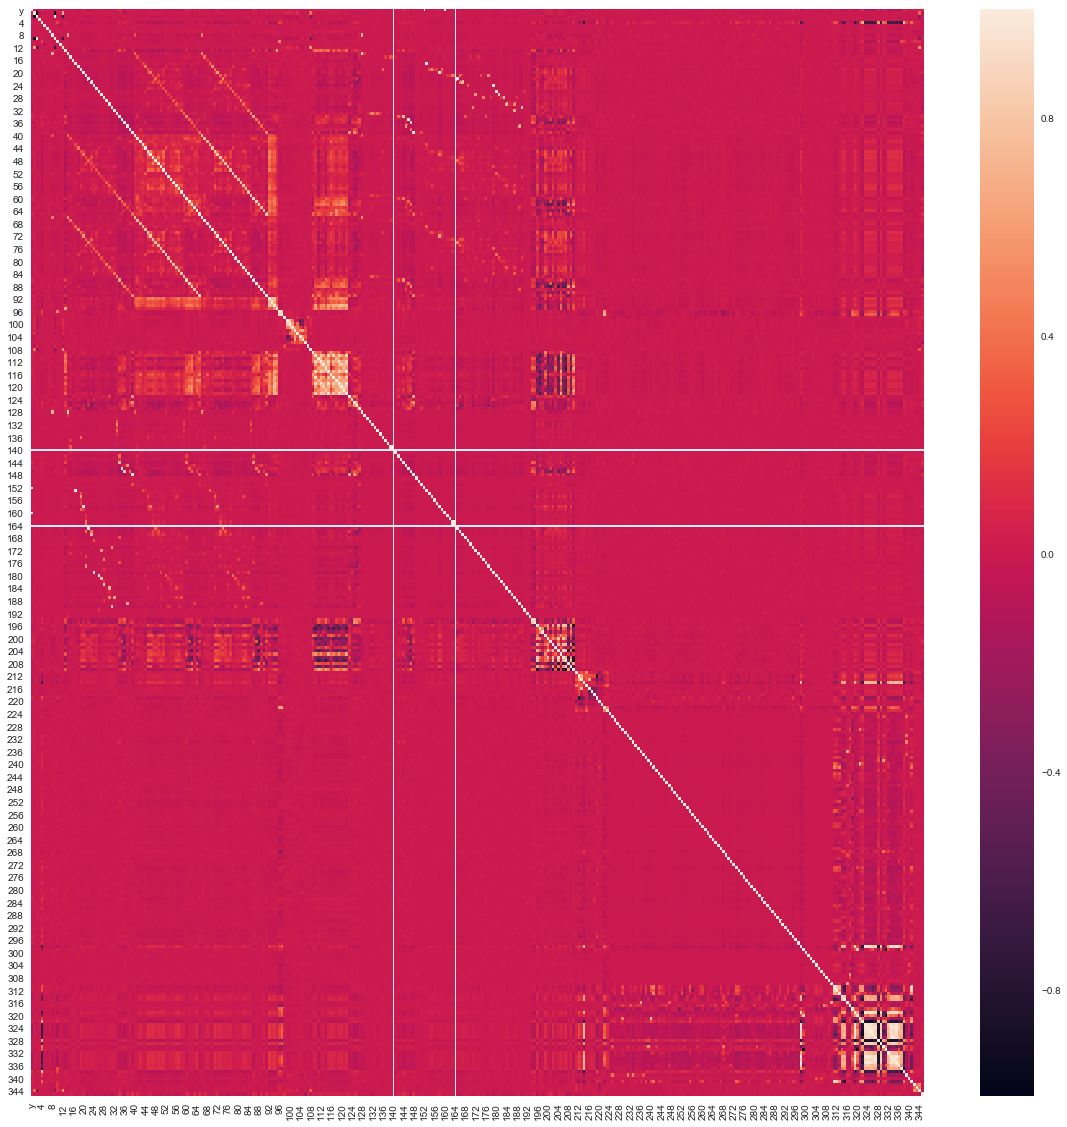

In [20]:
df_corr = df.corr()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(df_corr);

Можно выделить несколько групп признаков:
- первые полторы сотни положительно разно-коррелированных между собой признаков (разно-оранжевые квардраты с диагоналями)
- дюжину признаков в диапазоне 140-190 с сильными корреляциями к какому-то одному другому признаку (отдельные светлые точки)
- признаки с прямой и обратной корреляцией вида "один ко многим" в районе 190-230-х и особенно весь блок 310-340 (пёстные квадраты с вертикальными и горизонтальными одноцветными полосками)
- нулевые признаки (белые полоски, мы с ними уже выше познакомились)

Все остальные признаки между собой и с таргетом не особо связаны.

Поизучаем таргет..

In [21]:
df['y'].value_counts()

0.0    25077
1.0     5423
Name: y, dtype: int64

В трейне около 18% (=5423/30500) класса 1 - похоже, у нас плоховато сбалансированная выборка.
Запомним эту гипотезу для дальнейшей её адресации и пойдём дальше.

Посмотрим корреляции признаков с таргетом...

In [22]:
df_corr['y'][1:].sort_values(ascending=False)

338    0.155522
295    0.132264
86     0.125278
144    0.123040
34     0.122376
4      0.117453
60     0.108571
322    0.105359
201    0.091767
65     0.088044
219    0.084408
91     0.084141
328    0.083577
283    0.078105
297    0.070317
96     0.062351
10     0.061143
114    0.060720
233    0.060494
111    0.059197
         ...   
88    -0.086052
315   -0.097676
336   -0.101528
334   -0.101594
327   -0.102730
326   -0.114014
332   -0.124391
324   -0.125009
333   -0.125158
298   -0.127579
319   -0.127962
214   -0.128629
335   -0.129681
325   -0.131163
323   -0.132199
337   -0.145722
140         NaN
152         NaN
160         NaN
164         NaN
Name: y, Length: 345, dtype: float64

Есть пара дюжин заметных прямых (в начале списка) и обратных (в конце списка) корреляций. Нет сильно скоррелированных признаков, что исключает тривиальные решения задачи - ну и хорошо.

Первичный анализ данных можно считать завершённым, идём дальше.

###  Часть 3. Первичный визуальный анализ данных

Тут хорошо бы сделать вот что:
<font color='grey'>*Построены визуализации (распределения признаков, матрица корреляций и т.д.), описана связь с анализом, данным в пункте 2. Присутствуют выводы*</font>

Корреляции мы уже посмотрели выше.
Интересно было бы понимать распределения признаков, например, чтобы отделить дискретные и непрерывные, у дискретных поугадывать физический смысл, выделить кандидатов на OneHotEncoding и т.п.

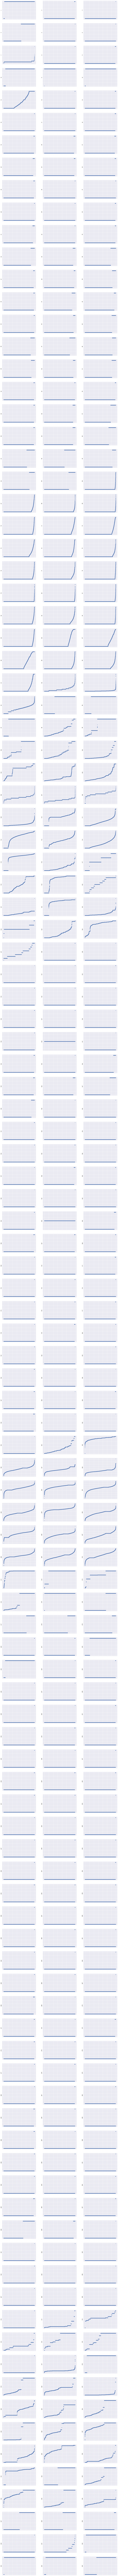

In [23]:
fig, axes = plt.subplots(115, 3, figsize=(20,460))
for ix in range(1, 115 * 3 + 1):
    row_ix, col_ix = divmod(ix - 1, 3)
    axes[row_ix, col_ix].plot(df[str(ix)].sort_values(ascending=True).values, '.')
    axes[row_ix, col_ix].tick_params(axis='both', labelbottom=False, labelleft=False)
    axes[row_ix, col_ix].set_ylabel(str(ix))
plt.show()

Признаки можно отнести к нескольким группам (причём иногда к нескольким сразу):
- бинарные (только min и max) - ничего не делаем
- много max - будем делать флажок is_max
- много min - будем делать флажок is_min
- много max, много min, остальные между - будем делать флажки is_max, is_min, is_between
- дискретные с несколькими значениями - будем выделять значения категорий и кодировать ohe-колоночками
- непрерывные - ничего не будем делать
- с выбросами - будем делать признак is_outlier_up или is_outlier_down и переопределять значение
- полностью с одним значением - просто дропнем

Посмотрим на всех глазами и запомним какой признак к каким группам относится:

In [24]:
# неохота всё в кавычках строками писать - поэтому быстро заполню цифорки в множествах, а потом сконвертирую 
many_maxes = {99, 100, 211, 212, 214, 314, 315, 319, 324, 325, 326, 327, 333, 334, 335}
many_mins = set(i for i in range(66, 91+1)) | set(i for i in range(109, 116+1)) | {118, 119, 121, 122, 125, 321, 331, 341}
many_mins_and_maxes_and_betw = ['13']
leveled = {7, 92, 93, 94, 98, 99, 100, 101, 102, 103, 106, 107, 108, 117, 118, 120, 121, 124, 127, 194, 212, 213, 214, 311,
           312, 313, 314, 315, 317, 341 } | set(i for i in range(319, 331+1)) | set(i for i in range(333, 336+1))
outliered = {121, 122, 123, 195, 197, 198, 204, 206, 321, 323, 336}
all_const = ['140', '164']

many_maxes = [str(i) for i in many_maxes]
many_mins = [str(i) for i in many_mins]
leveled = [str(i) for i in leveled]
outliered = [str(i) for i in outliered]

По аутлаерам выберем коэффициент для дальнейшего применения метода межквартильного размаха при отсечении выбросов

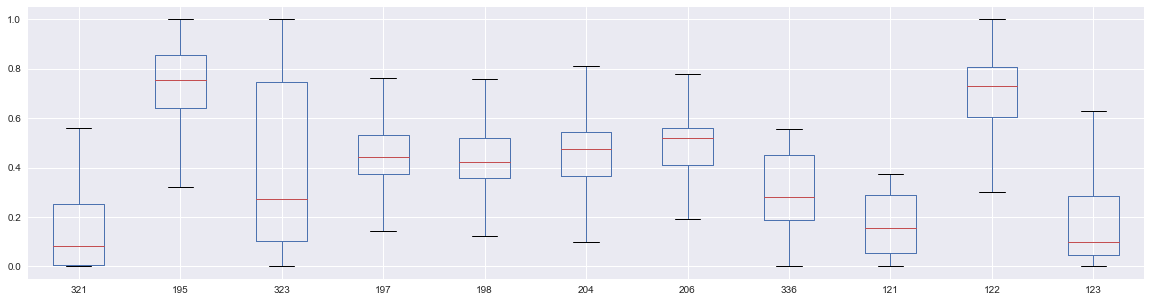

In [65]:
df[outliered].boxplot(figsize=(20,5), whis=1.5); #1.5 - по умолчанию, многовато оставляет за границей

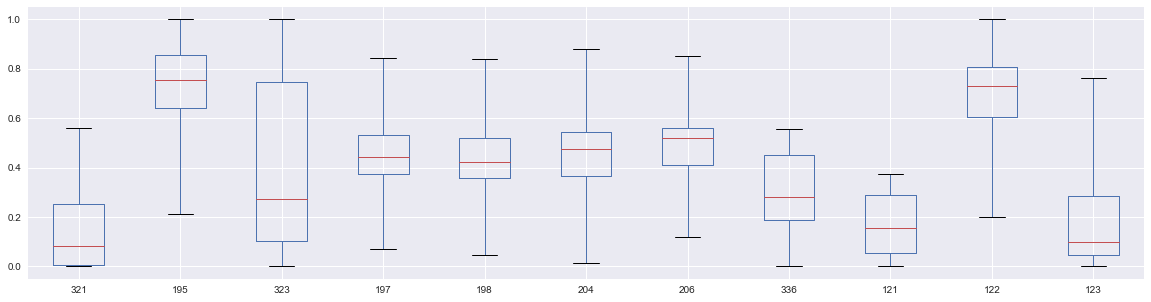

In [66]:
df[outliered].boxplot(figsize=(20,5), whis=2.0); # лучше

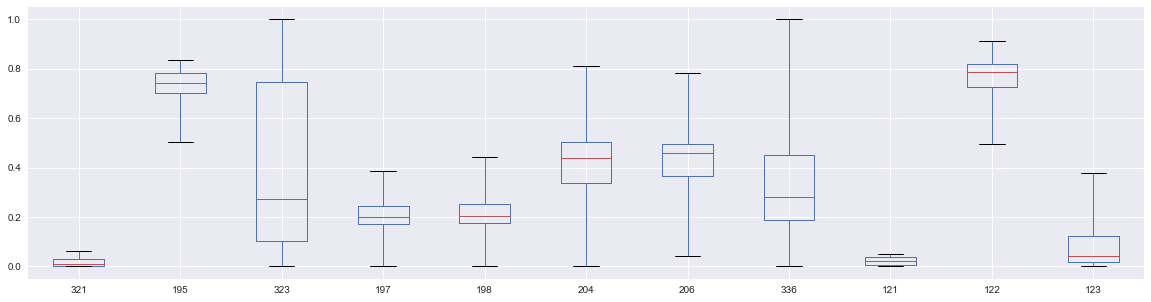

In [27]:
df[outliered].boxplot(figsize=(20,5), whis=2.5); # ещё лучше

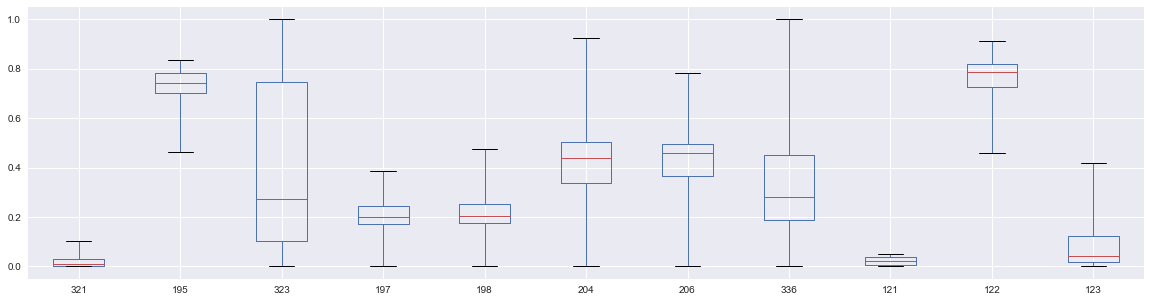

In [28]:
df[outliered].boxplot(figsize=(20,5), whis=3.0); # достаточно хорошо

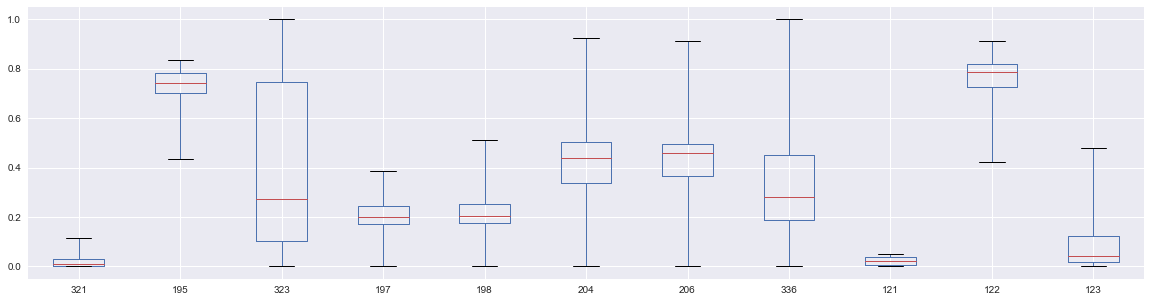

In [29]:
df[outliered].boxplot(figsize=(20,5), whis=3.5); # многовато: сожрали интерквартильным размахом почти все выбросы

Посмотрим, как признаки связаны с таргетом:

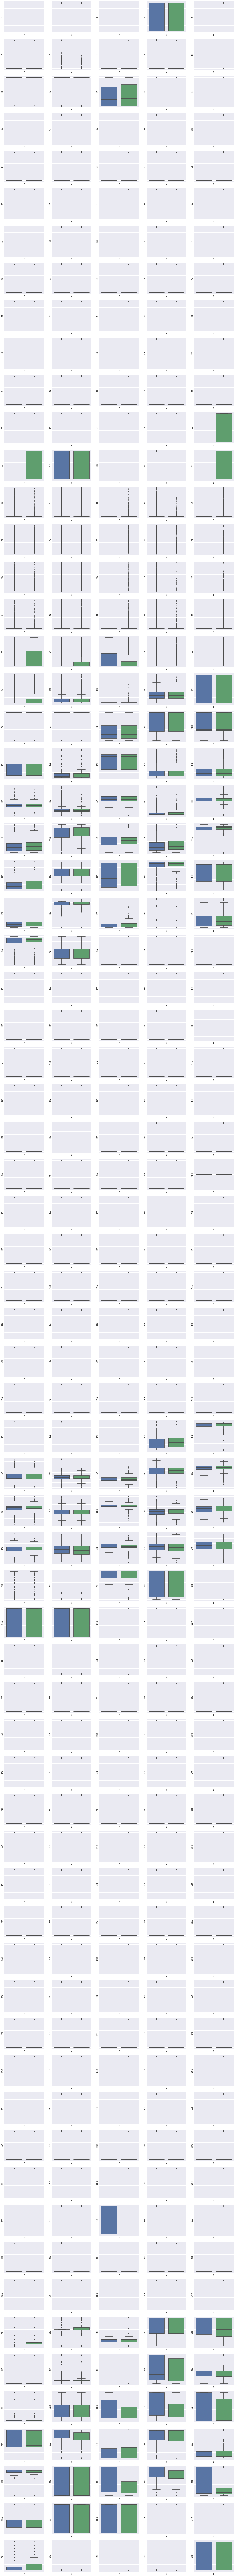

In [30]:
fig, axes = plt.subplots(69, 5, figsize=(20,230))
for ix in range(1, 69 * 5 + 1):
    row_ix, col_ix = divmod(ix - 1, 5)
    sns.boxplot(x='y', y=str(ix), data=df, ax=axes[row_ix, col_ix])
    axes[row_ix, col_ix].set_ylabel(str(ix))
    axes[row_ix, col_ix].tick_params(axis='both', labelbottom=False, labelleft=False)
plt.show()

Признаков, по-разному ведущих себя на при разных значениях таргета, полтора десятка. Запомним их чтобы потом сравнить с важностью в бустинге.

In [31]:
target_diff_features = {61, 61, 65, 86, 87, 88, 298, 312, 323, 324, 333, 334, 335, 341}
target_diff_features = [str(i) for i in target_diff_features]

Смотреть по всем признакам распределения, подбирать трансформацию к нормальному распределению, логарифмировать, искать попарные влияния не будем т.к. задача обезличена и связи с физическим миром уничтожены, в угадайку времени играть нет, проект учебный, а не кегловый на корову.

Готово, для каждого признака сформировали мнение о нём и планы по его дальнейшей трансформации. 

###  Часть 4. Инсайты, найденные зависимости

Тут хорошо бы сделать вот что:
<font color='grey'>*Найдены и выдвинуты предположения о природе различных корреляций/пропусков/закономерностей и выбросов, найденных в предыдущих пунктах. Есть пояснение, почему они важны для решаемой задачи*</font>

Поскольку задача специально обезличена и оторвана авторами от физического мира, выявлять гипотезы на основании физики сильно затруднительно.

Зная хотя бы, что это клиенты банка, то хорошо бы, конечно, поразгадывать по значениям переменных, где там пол, возраст, дата, остаток по счёту, пользование другими финансовыми продуктами и т.п. Но задача учебная, важно знать что так можно делать и понимать применимость к этому датасету, но до дедлайна нет времени часами сидеть разгадывать. 

Но, понимая, откуда задача, всё же можно сделать несколько предположений и далее их потестировать в модели:
- клиентами Модульбанка являются малые предприниматели - ребята, которым всё время не хватает оборотных средств, и которым её негде взять, кроме как лично на себя (залогов, поручительств и прочего у малого бизнеса нет)
- знаем, что таргет - это подключение какого-то продукта или услуги. Ключевыми факторами в принятии решений компаниями малого бизнеса почти всегда является личное благосостояние самого предпринимателя. Возможно, это нам поможет объяснить распределения и связи выявленных фич с таргетом  
- в частности, клиентов в банке много, работает закон больших чисел в описании их типовых поведений т.е. поведение клиентов с точки зрения потребления финансовых продуктов и услуг, как правило, достаточно шаблонно. Таким образом, можно будет выделить несколько типовых профилей / сегментов / кластеров - и таргет будет насколько-то ими объясняться.

Давайте посмотрим на корреляции с таргетом тех признаков, которые мы выделили как наиболее характеризующие:

In [32]:
df_corr['y'][target_diff_features].abs().sort_values(ascending=False)

323    0.132199
335    0.129681
298    0.127579
86     0.125278
333    0.125158
324    0.125009
334    0.101594
65     0.088044
88     0.086052
341    0.045582
312    0.030634
61     0.024671
87     0.023407
Name: y, dtype: float64

Распределение значений отмеченных нами признаков интересное: 323/324 похожи на FICO score физических лиц, 86/87/88 похожи на рассчитываемый лимит автоматического скоринга. Тогда, если гипотетически таргет - это какой-то кредитный продукт, например, овердрафт к счёту [а что ещё может волновать банк? :-) ], то модель начинает обретать смысл:
- овердрафт к счёту могут подключить только те, кому скоринг одобрил, и не берут те, котому скоринг не одобрил (см. бокс-плоты 86/87/88)
- овердрафт к счёту подключают те, у кого FICO score не высокий (см. бокс-плоты 323, 324) т.к. те, у кого FICO score невысокий, не закредитованы и им деньги не очень нужны

На этом главную гипотезу модели и найденные зависимости можно, с учётом обезличенности данных, считать описанными. Едем дальше.

###  Часть 5. Выбор метрики

Тут хорошо бы сделать вот что:
<font color='grey'>*Есть разумное обоснование выбора метрики качества модели. Описаны моменты, влияющие на выбор метрики качества (решаемая задача, цель решения, количество классов, дисбаланс классов, прочее)*</font>

Вообще-то авторы нам прямо сказали, что **оценкой качества в задаче является ROC-AUC:**

<img src='../../img/Validation.jpg' width=50%>

Но мы так просто не сдадимся и порассуждаем, а какую бы мы сами выбрали метрику для такой задачи.

Итак:
- это задача классификации - значит, применима метрика точности (accuracy)
- но это задача бинарной классификации - значит, лучше подходят метрики на основе матрицы несоответствий: точность, полнота, F1
- классы несбалансированные - значит, обычные точность и полнота не подойдут - нам нужна устойчивая к несбалансированным классам метрика, например (вот удивительно, да?), ROC AUC
- в данной задаче модель будет использоваться для наиболее точного прогноза на закрытых тестовых данных организаторов - значит, нас волнует по факту не значение спрогнозированной вероятности, а относительный порядок наших прогнозов - и тогда тем более ROC AUC
- в жизни модель будет использоваться не для классификации, а для прогнозирования вероятности приобретения продукта ИКС - вот тут уже ROC AUC будет менее важен, и на первый план выйдут метрики регресии, такие как средняя <какая-нибудь> ошибка, R-квадрат.

###  Часть 6. Выбор модели

Тут хорошо бы сделать вот что:
<font color='grey'>*Произведен выбор модели. Описан процесс выбора и связь с решаемой задачей*</font>

Ну, во-первых, <img src='../../img/xgboost-all-the-things.jpg' width=30%>

Если на мгновение отложить в сторону XGBoost, то авторитетные ресурсы рекомендуют нам SVM или решающий лес - и можно предположить почему: бинарная классификация, фич много, данных немного, переобучаться не хочется.
<img src='../../img/model_selection_ms.jpg' width=100%>
<img src='../../img/model_selection_2.jpg' width=100%>

Нейронка вряд ли зайдёт: маловато наблюдений. Да и трешевых столбцов много, что, при общей низкой скорости обучения сетки, сделает её применение на моём ноуте совсем неразумным.

Как вариант, можно постекать разные модели, но вспоминаем тут, что это учебная задача, а не кегл на корову. Хотя, мини-стекинг будет - см. кластеризацию далее. 

Собственно, может быть, ещё нам в решении задачи поможет кластеризация методом k-средних (если её скормить основной модели) - посмотрим.

###  Часть 7. Предобработка данных 

Тут хорошо бы сделать вот что:
<font color='grey'>*Проведена предобработка данных для конкретной модели. При необходимости есть и описано масштабирование признаков, заполнение пропусков, замены строк на числа, OheHotEncoding, обработка выбросов, отбор признаков с описанием используемых для этого методов. Корректно сделано разбиение данных на обучающую и отложенную части*</font>

#### 7.1 Предобработка данных

Для этого датасета получилось, что прямо отдельно в этом пункте никакого кода предобработки не требуется т.к.:
- все признаки уже отмасштабированы в интервал 0..1 (или даже чуть-чуть уже)
- выбросы я буду переопределять значениями поближе к основной массе товарищей позже, после создания новых признаков is_outlier 
- признаки с аутлаерами я буду перемасштабировать позже, после переопределения выбросов
- пропусков в признаках нет - мы это уже посмотрели
- строк нет - всё сразу числами, мы это уже посмотрели
- OneHotEncoding-похожее преобразование я буду делать в создании новых признаков, восстанавливая значения категорий из дискретных признаков
- отбор признаков для определения целевого набора признаков я буду делать позже, в настройке гиперпараметров, т.к. набор признаков сам по себе является гиперпараметром

#### (анонс) 7.2 Разбиение данных на обучающую и отложенную части

Разбиение данных на обучающую и отложенную части я сделаю после Части "Создание новых признаков и описание этого процесса" чтобы не копипастить код преобразований данных для каждого датасета (а их у нас разведётся немало - позже покажу почему), не ошибаться с заменами после копипастов и т.п.

Таким образом, все нужные механизмы предобработки данных для этого датасета понятны и делаться будут, просто не в части 7, а в других частях проекта.

###  Часть 8 (в оригинале 9). Создание новых признаков и описание этого процесса

*Примечание: я поменял местами 8 и 9 т.к. генерю новые признаки ДО того, как подбираю параметры модели*

Тут хорошо бы сделать вот что:
<font color='grey'>*Созданы новые признаки. Дано обоснование: логическое (например, у птиц температура тела на несколько градусов выше человеческой, значит вирус ХХХ не выживет в такой среде), физическое (например, радуга означает, что источник света расположен сзади; расчет величины по физическому закону с использованием данных признаков) или другое (скажем, признак построен после визуализации данных). Обоснование разумно описано. Полезность новых признаков подтверждена статистически или с помощью соответствующей модели*</font>

Какие признаки добавлять - мы уже установили при анализе данных и визуальном анализе.

Для leveled-признаков посмотрим, сколько их надо будет добавить:

In [33]:
vc_sizes = []
for col in leveled:
    vc_sizes.append(df[col].nunique())
print(np.sum(vc_sizes))

6441


6441 колонок многовато для дальнейшего обучения на ноутбуке, выберем разумное число поменьше:

In [34]:
np.sort(vc_sizes)

array([   5,    5,    5,   10,   10,   11,   11,   12,   12,   12,   12,
         13,   18,   21,   23,   27,   62,   71,   80,   81,   81,   82,
         83,   84,   84,   85,   85,   85,   85,   85,   85,   85,   85,
         85,   85,   85,   85,  197,  197,  324,  368,  370,  370,  509,
        572,  597, 1002])

85 представляется разумным т.к. дальше единичные признаки - мы избежим добавления 4,5 тысяч колонок

Пройдёмся по признакам, посмотрим, к каким группам они относились, и достроим нужные комплекты по группам.

In [35]:
%%time
for col in df.columns:
    if col in many_maxes:
        max_val = df[col].max()
        df[col + '_is_max'] = (df[col] == max_val) * 1
        
    if col in many_mins:
        min_val = df[col].min()
        df[col + '_is_min'] = (df[col] == min_val) * 1
        
    if col in many_mins_and_maxes_and_betw:
        max_val = df[col].max()
        min_val = df[col].min()
        df[col + '_is_max'] = (df[col] == max_val) * 1
        df[col + '_is_min'] = (df[col] == min_val) * 1
        df[col + '_is_between'] = ((df[col] > min_val) & (df[col] < max_val)) * 1
        
    if col in leveled:
        if df[col].nunique() <= 85:
            vc = df[col].value_counts().reset_index(drop=False)
            for i_vc in vc.index:
                df[col + '_' + str(i_vc)] = (df[col] == vc.loc[i_vc]['index']) * 1

    if col in outliered:
        q25, q75 = np.percentile(df[col], [25, 75])
        iqr = q75 - q25
 
        min_val = q25 - (iqr * 3.0) # 3.0 мы выбрали в визуальном анализе данных по аутлаерам
        max_val = q75 + (iqr * 3.0)
        
        df[col + '_is_outlier_down'] = (df[col] < min_val) * 1
        df[col + '_is_outlier_up'] = (df[col] > max_val) * 1
        
        df.loc[df[col] < min_val, col] = min_val
        df.loc[df[col] > max_val, col] = max_val

Wall time: 47 s


Константные признаки просто дропнем:

In [36]:
df.drop(columns=all_const, inplace=True)

Смасштабируем всё в [0..1] т.к. нам может понадобиться применять разные модели, а им на вход часто нужны [0..1]:

In [37]:
scl = MinMaxScaler()
df = pd.concat([df['y'], pd.DataFrame(scl.fit_transform(df.drop(columns=['y'])), index=df.index, columns = df.columns[1:])],
                axis='columns')

In [38]:
df.shape

(34666, 2361)

У нас, предположительно (т.к. не знаем физику данных), несколько десятков категориальных признаков. Полезным подходом для вытягивания смысла из категориальных признаков является их переклеивание между собой парами, тройками и т.д., но я воздержусь: и так уже на получившихся  2-х тысячах признаков мой ноут пыхтит по 15-30 минут. 

Другая тема - кластеризация клиентов банка - может дать прирост если её скормить основной модели - попробуем.
Причина простая: поведение клиентов с точки зрения потребления финансовых продуктов и услуг, как правило, достаточно шаблонно т.е. можно выделить несколько типовых профилей / сегментов / кластеров.

Количество классов не знаем, но раз это клиенты банка - значит, разных профилей поведения там или вообще небольшое или обозримое количество. Поэтому попробуем 5, 10 и 15. Обучать можно на всём датасете без таргета т.к. все признаки тестового датасета у нас есть и какие-то другие данные не будут скармливаться модели. 

In [39]:
%%time
k5_pred = KMeans(n_clusters=5, random_state=RANDOM_SEED).fit_predict(df.drop(columns=['y']))
k10_pred = KMeans(n_clusters=10, random_state=RANDOM_SEED).fit_predict(df.drop(columns=['y']))
k15_pred = KMeans(n_clusters=15, random_state=RANDOM_SEED).fit_predict(df.drop(columns=['y']))

Wall time: 6min 43s


In [40]:
df = pd.concat(
    [df, pd.DataFrame(np.hstack((k5_pred[None].T, k10_pred[None].T, k15_pred[None].T)),
                      index=df.index, columns=['k5', 'k10', 'k15'])],
    axis='columns')

In [41]:
df.shape

(34666, 2364)

К изначальным 345 мы нагенерили ещё плюс 2 тысячи признаков - оооочень вряд ли прям все они нам нужны для дальнейшей настройки модели.

Будем выберать самые полезные признаки для модели не в этом пункте, а позже, при настройке гиперпараметров.

На этом генерация признаков и её описание завершено.

#### (флешбек из части 7) 7.2 Разбиение данных на обучающую и отложенную части

Поскольку к моменту выполнения индивидуального проекта он-лайн этап с возможностью загрузки решения уже завершился и нет возможности проверяться на оригинальных тестовых данных, придётся сделать себе локальные трейн и тест из имеющегося трейна (поскольку считаем, что упорядоченности в данных нет, то для разумности и непредвзятости при формировании тестовых данных просто  (1) сохраним от исходной выборки относительную долю теста от данных и (2) распределение таргета + (3) рандомизируем)

In [42]:
df_train_local, df_test_local, y_train_local, y_test_local = \
    train_test_split(df[df['y'].notna()].drop(columns=['y']),
                     df[df['y'].notna()]['y'],
                     test_size=df_test.shape[0] / (df_train.shape[0] + df_test.shape[0]),
                     stratify=df[df['y'].notna()]['y'],
                     random_state=RANDOM_SEED)

Авторы датасета говорят нам, что:
<font color='grey'>*Рейтинг строится на 30% тестового датасета, финальный рейтинг будет построен на 70% тестового датасета и может отличаться.*</font>

Участники топ-6 мест в публичном и финальном рейтинге полностью не совпадают т.е. явно имеет место переобучение на лидерборде.

Хорошо, давайте тоже сделаем себе локальные public и private тестовые датасеты где и будем оценивать наше переобучение:

In [43]:
df_test_local_public, df_test_local_private, y_train_local_public, y_test_local_private = \
    train_test_split(df_test_local,
                     y_test_local,
                     test_size=0.7,
                     stratify=y_test_local,
                     random_state=RANDOM_SEED)

In [44]:
# проверим что получилось
df_train_local.shape, df_test_local.shape, y_train_local.shape, y_test_local.shape

((26834, 2363), (3666, 2363), (26834,), (3666,))

In [45]:
df_test_local_public.shape, df_test_local_private.shape, y_train_local_public.shape, y_test_local_private.shape

((1099, 2363), (2567, 2363), (1099,), (2567,))

###  Часть 9 (в оригинале 8). Кросс-валидация и настройка гиперпараметров модели

*Примечание: я поменял местами 8 и 9 т.к. подбираю параметры модели ПОСЛЕ того, как генерю новые признаки*

С помощью неглубокого, пракически дефолтного, бустинга выявим наиболее полезные фичи:

In [46]:
%%time
params = {
    'n_estimators': 75,
    'subsample': 0.5,
    'scale_pos_weight': y[y == 0].size / y[y == 1].size,
    'base_score': y_train_local.mean(),
    'random_state': RANDOM_SEED
}
clf = xgb.XGBClassifier(**params)
clf.fit(df_train_local, y_train_local)

Wall time: 3min 3s


Посмотрим на важность фич:

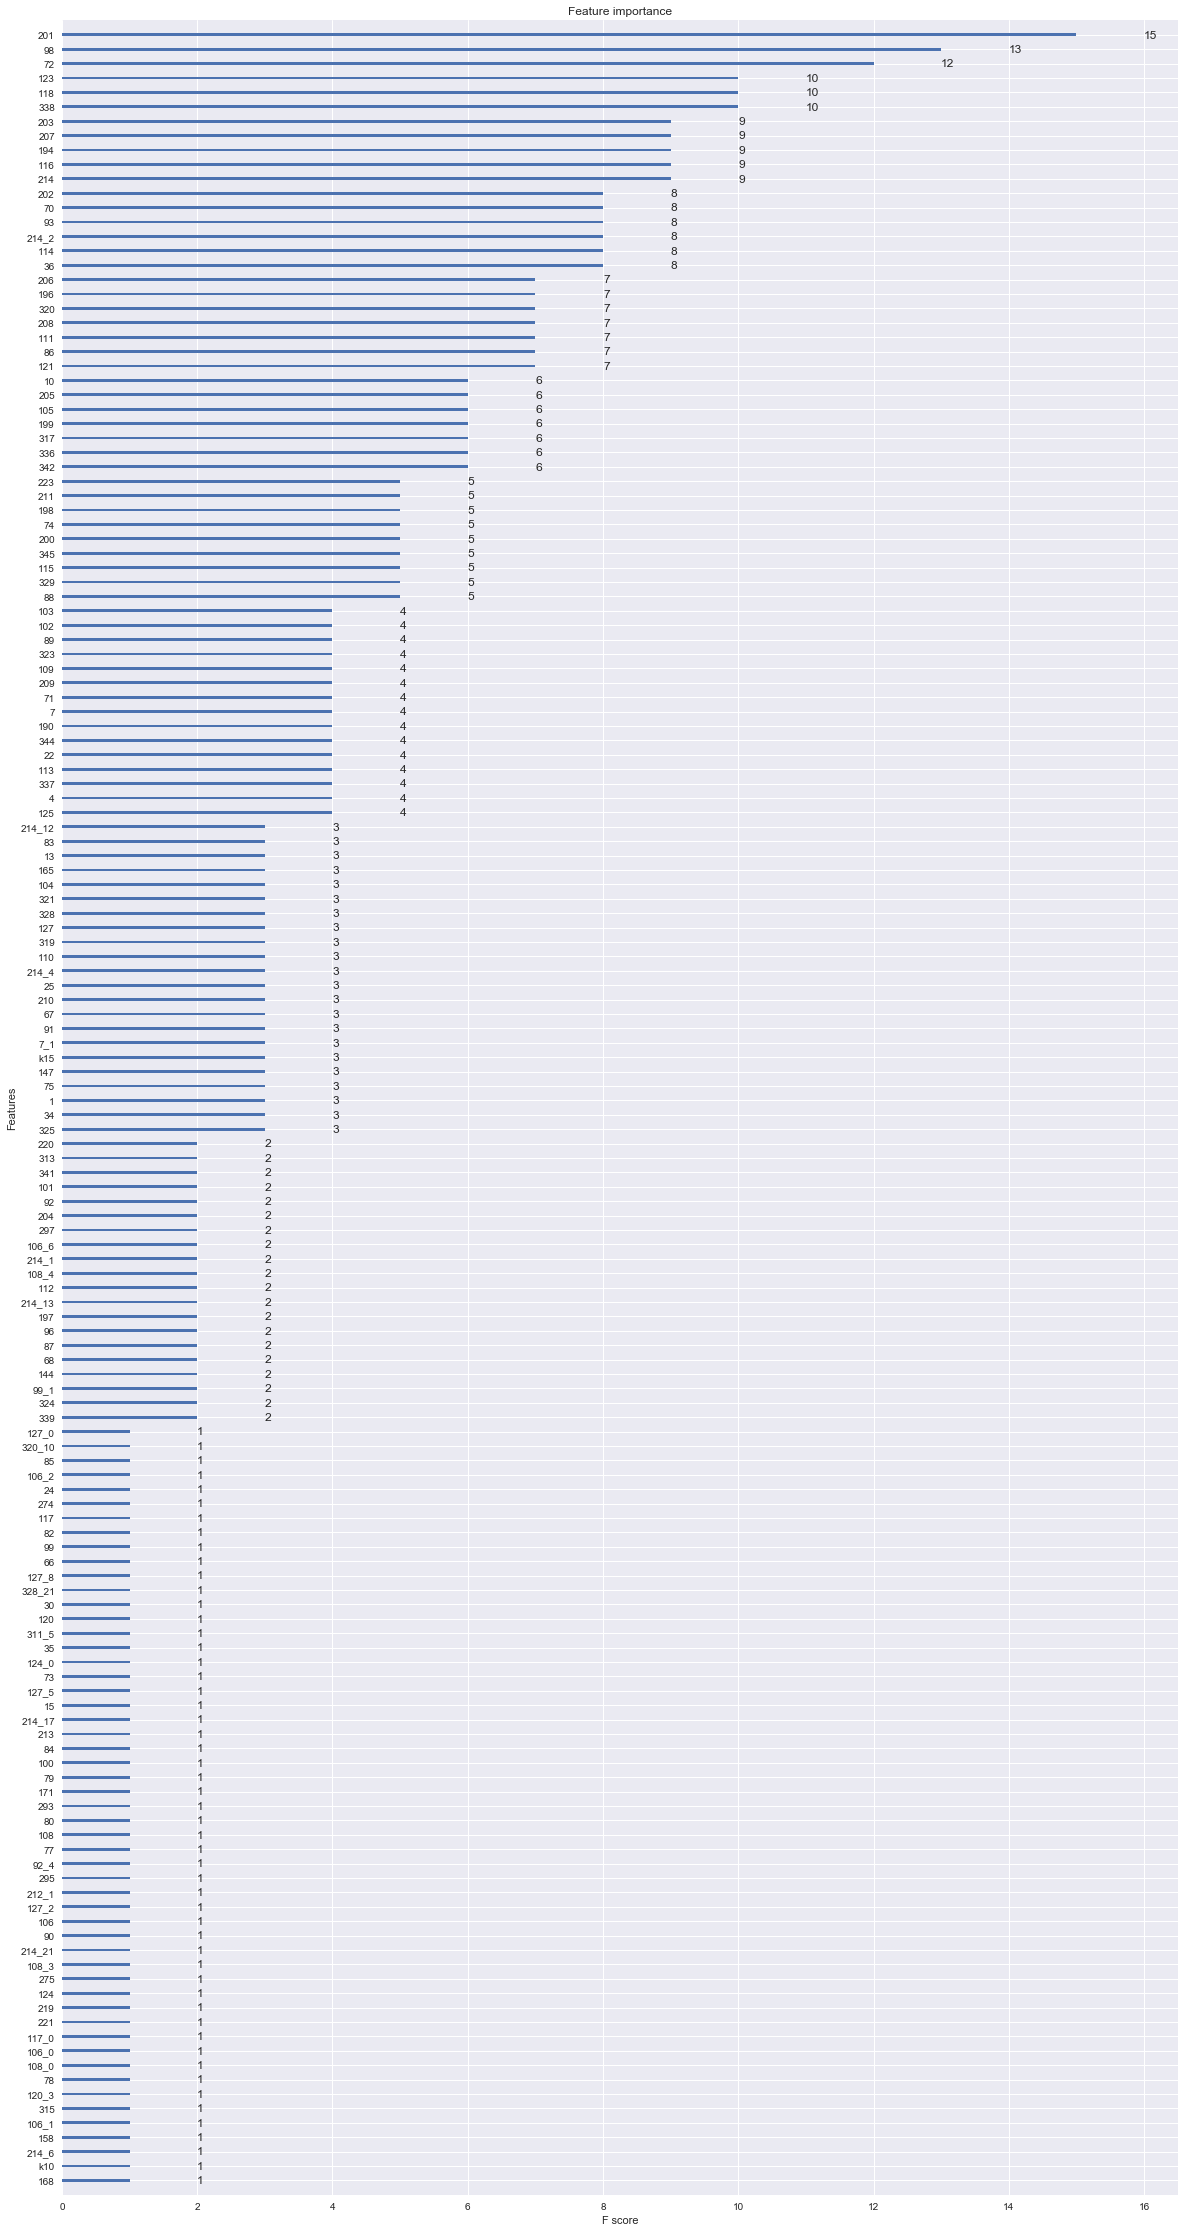

In [47]:
sns.set(rc={'figure.figsize':(20,40)})
xgb.plot_importance(clf);

Достанем важность фич чтобы с экрана не перепечатывать ))

In [48]:
ft_weights = pd.DataFrame(clf.feature_importances_, columns=['weights'], index=df.columns[1:])

plot_importance говорит нам в том числе и про минимальные значимые фичи - посмотрим, какое у них значение значимости, и посмотрим сколько вообще значимых фич

In [49]:
ft_weights.loc['k10']

weights    0.001931
Name: k10, dtype: float32

In [50]:
ft_weights[ft_weights['weights'] >= 0.001930].size

150

In [51]:
ft_weights.sort_values(by='weights', ascending=False).iloc[:160]

,weights
201,0.028958
98,0.025097
72,0.023166
123,0.019305
118,0.019305
338,0.019305
207,0.017375
214,0.017375
194,0.017375
203,0.017375


Фичи с важностью ниже 0.001931 уже не нужны. Возьмём дальше с нами всех тех, кто больше:

In [52]:
imp_cols = ft_weights[ft_weights['weights'] >= 0.001930].index

In [53]:
imp_cols

Index(['1', '4', '7', '10', '13', '15', '22', '24', '25', '30',
       ...
       '214_6', '214_12', '214_13', '214_17', '214_21', '311_5', '320_10',
       '328_21', 'k10', 'k15'],
      dtype='object', length=150)

Итого у нас получилось 150 фич, важных для модели.
Посмотрим, сколько там тех, которые мы увидели на визуальном анализе:

In [54]:
ft_weights.loc[np.intersect1d(target_diff_features, imp_cols)].sort_values(by='weights', ascending=False)

,weights
86,0.013514
88,0.009653
323,0.007722
324,0.003861
341,0.003861
87,0.003861


Выводы нашего визуального анализа подтверждаются: 6 фич, увиденных глазами, - среди важных с точки зрения модели.
Также эти фичи как раз находятся в двух регионах, увиденных нам ранее на хитмэпе при анализе данных: положительно разно-коррелированные и пёстрые квадраты.

Подход к кросс-валидации следующий: в предположении, что нужные фичи мы уже нагенерили, далее ключевыми параметрами нашего упражнения будут бустер, количество фич, learning_rate, max_depth, n_estimators, subsample. Другие параметры менее важны чем эти - поэтому сначала настроимся тут.

Поскольку выборка плоховато сбалансированная - сразу поставим поставим scale_pos_weight заинициализируем классификатор средним по таргету.

Дока по XGBoost говорит нам: "<font color='grey'>*If you care only about the ranking order (AUC) of your prediction -
balance the positive and negative weights via scale_pos_weight and use AUC for evaluation*</font>" - да, мы боремся только за AUC-метрику, будем ставить scale_pos_weight. Дока рекомендует "<font color='grey'>*...typical value to consider: sum(negative cases) / sum(positive cases)*</font>" - с него и начнём.

Дока по XGBoost говорит нам: "<font color='grey'>*kwargs is unsupported by Sklearn. We do not guarantee that parameters passed via this argument will interact properly with Sklearn.*</font>" - ок, услышали, но попробуем т.к. уж очень наглядно и лаконично получается.

In [55]:
params = {
    'booster': 'gbtree',
    
    # параметры деревянного бустера
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 75,
    'subsample': 1,
    'scale_pos_weight': y[y == 0].size / y[y == 1].size,
    
    # параметры обучения
    'objective': 'binary:logistic',
    'base_score': y_train_local.mean(),
    'eval_metric': 'auc',
    'random_state': RANDOM_SEED,
    
}

In [56]:
param_grid = [{
    #'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2, 0.4, 1], # 1-ый поиск, наметили 0.1 с 0.734137473946
    #'max_depth': [4, 5, 6, 7], # 2-ой поиск, наметили 5 с 0.73388072958
    #'n_estimators': np.linspace(50, 200, 7).astype('int'), # 3-ий поиск, наметили 75 с 0.734311200295
    'subsample': [0.5, 0.75, 1.0] # 4-ый поиск, наметили 1 c 0.734311200295
}]

Будем проводить 5-кратную стратифицированную кросс-валидацию т.к. рекомендуемую индустрией 10-кратную на ноуте долго считать даже на нашем небольшом датасете

In [57]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [58]:
%%time
clf = xgb.XGBClassifier(**params)
gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=cv)
gs=gs.fit(df_train_local[imp_cols], y_train_local)
print(gs.best_score_)
print(gs.best_params_)

0.734311200295
{'subsample': 1.0}
Wall time: 5min 22s


###  Часть 10. Построение кривых валидации и обучения

Тут хорошо бы сделать вот что:
<font color='grey'>*Построены кривые валидации и обучения. Дана верная интерпретация*</font>

Посмотрим с помощью кривых обучения как ведёт себя модель с точки зрения смещения и дисперсии:

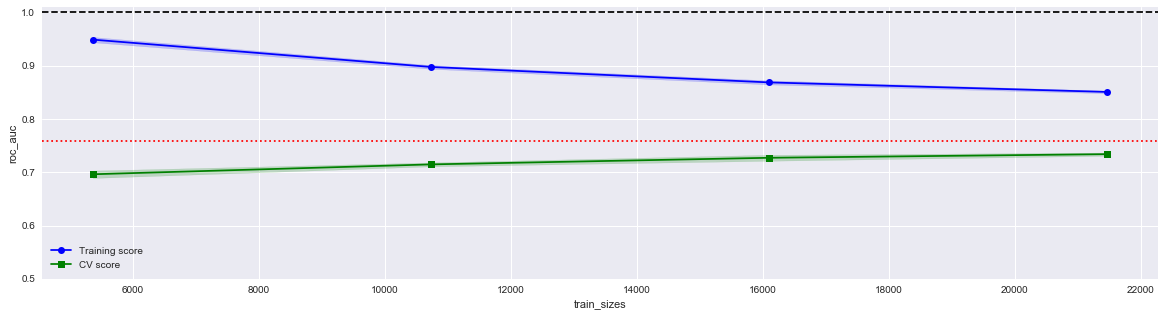

Wall time: 4min 8s


In [59]:
%%time
params = {
    'booster': 'gbtree',
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 75,
    'subsample': 1,
    'scale_pos_weight': y[y == 0].size / y[y == 1].size,
    'objective': 'binary:logistic',
    'base_score': y_train_local.mean(),
    'eval_metric': 'auc',
    'random_state': RANDOM_SEED,
}

train_sizes, train_scores, test_scores = learning_curve(estimator=xgb.XGBClassifier(**params),
                                                        X=df_train_local[imp_cols],
                                                        y=y_train_local,
                                                        train_sizes=[0.25, 0.5, 0.75, 1.0],
                                                        cv=cv,
                                                        scoring='roc_auc',
                                                        shuffle=True,
                                                        random_state=RANDOM_SEED)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(20, 5))

plt.xlabel('train_sizes')
plt.ylabel('roc_auc')
plt.ylim(0.5, 1.01)

plt.plot(train_sizes,
             train_scores_mean,
             label="Training score",
             color="b", marker='o')

plt.plot(train_sizes,
             test_scores_mean, 
             label="CV score",
             color="g", marker='s')

plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="b")

plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=0.75869667, color='r', ls='dotted')
plt.axhline(y=1.0, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

Целевое значение взято от лучшего официального результата соревнования 0.75869667. Это наводит на мысли о том, что маловато фичей в данных чтобы определить таргет - хотя, конечно, надо топить за 1.0.

Видим, что наша такая быстро собранная модель обладает достаточно высокой дисперсией: большой разрыв между верностью на тренировочном наборе и точностью на кросс-валидации - подумаем что нам может помочь.
Вариант найти побольше тренировочных данных нам не подходит: данных просто больше нет. Вариант нагенерить побольше токовых признаков, конечно, классный, и всегда должен в первую очередь использоваться, но в моменте неприменимый: делаем учебную задачу, а не гоняем за корову. 

Попробуем уменьшить сложность модели:
- снизим количество признаков
- уменьшим максимальную глубину деревьев
- ещё увеличим  min_child_weight
- добавим больше "случайности" за счет subsample

In [60]:
ft_weights[ft_weights['weights'] >= 0.005].size

77

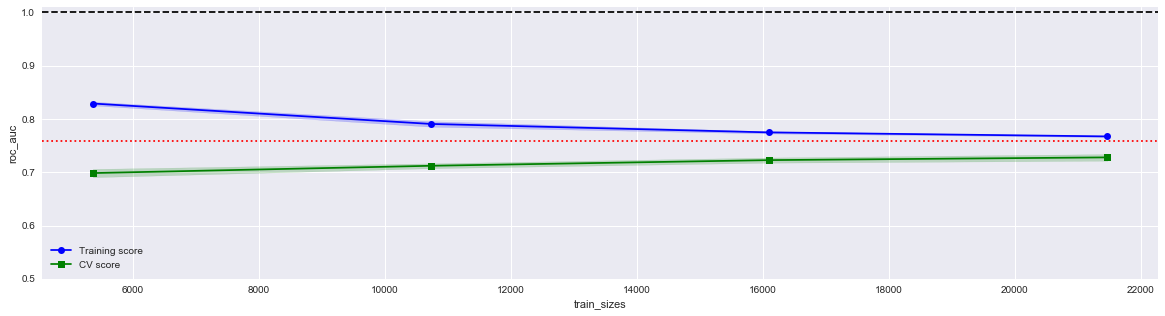

Wall time: 1min 33s


In [61]:
%%time
params = {
    'booster': 'gbtree',
    'max_depth': 3, # изменено с 5
    'learning_rate': 0.1,
    'n_estimators': 75,
    'subsample': 0.5, # изменено с 1.0
    'scale_pos_weight': 1.25 * y[y == 0].size / y[y == 1].size, # увеличено на 25%
    'objective': 'binary:logistic',
    'base_score': y_train_local.mean(),
    'eval_metric': 'auc',
    'random_state': RANDOM_SEED,
}

imp_cols_subset = ft_weights[ft_weights['weights'] >= 0.005].index # в два раза сокращено количество фич

train_sizes, train_scores, test_scores = learning_curve(estimator=xgb.XGBClassifier(**params),
                                                        X=df_train_local[imp_cols_subset],
                                                        y=y_train_local,
                                                        train_sizes=[0.25, 0.5, 0.75, 1.0],
                                                        cv=cv,
                                                        scoring='roc_auc',
                                                        shuffle=True,
                                                        random_state=RANDOM_SEED)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(20, 5))

plt.xlabel('train_sizes')
plt.ylabel('roc_auc')
plt.ylim(0.5, 1.01)

plt.plot(train_sizes,
             train_scores_mean,
             label="Training score",
             color="b", marker='o')

plt.plot(train_sizes,
             test_scores_mean, 
             label="CV score",
             color="g", marker='s')

plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="b")

plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=0.75869667, color='r', ls='dotted')
plt.axhline(y=1.0, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

Видим, что наши методы борьбы с дисперсией помогли: модель теперь ведёт себя намного более единообразно на тренировочных данных и кросс-валидации, чем ещё шаг назад.

Повыбираем значение для количества деревьев с помощью проверочных кривых:

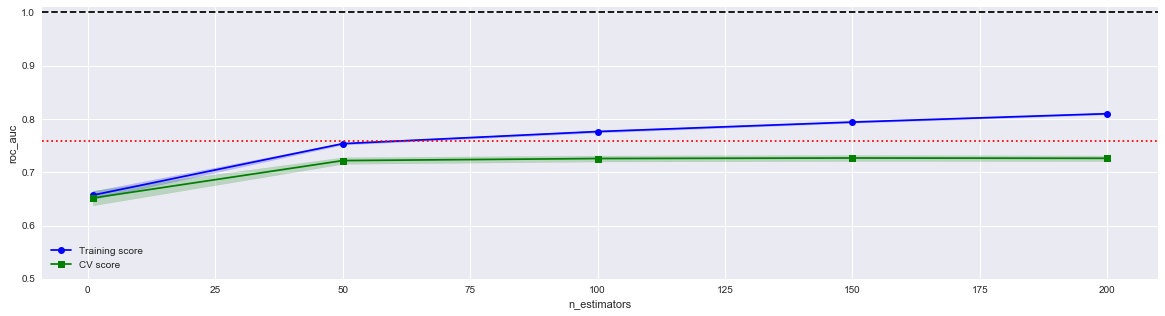

Best cross-validation result (0.73) obtained for 150 trees
Wall time: 4min 36s


In [62]:
%%time
params = {
    'booster': 'gbtree',
    'max_depth': 3,
    'learning_rate': 0.1, 
    'subsample': 0.5,
    'scale_pos_weight': 1.25 * y[y == 0].size / y[y == 1].size,
    'objective': 'binary:logistic',
    'base_score': y_train_local.mean(),
    'eval_metric': 'auc',
    'random_state': RANDOM_SEED,
}

n_estimators_range = np.linspace(1, 200, 5).astype('int')

train_scores, test_scores = validation_curve(
    xgb.XGBClassifier(**params),
    df_train_local[imp_cols_subset], y_train_local,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='roc_auc'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(20, 5))

plt.xlabel('n_estimators')
plt.ylabel('roc_auc')
plt.ylim(0.5, 1.01)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="b", marker='o')

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="CV score",
             color="g", marker='s')

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="b")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')
plt.axhline(y=0.75869667, color='r', ls='dotted')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], 
                                                                             n_estimators_range[i]))

Видим, что:
- у модели разброс ошибки быстро падает и становится совсем небольшим - модель стабилизируется,
- доля правильных ответов на обучении продолжает расти, хотя на валидации замирает,
- даже с найденным хорошим значением количества деревьев до хорошего результата ROC-AUC ещё грести и грести. 

И похоже, с моделью всё норм и мы просто не сгенерили хорошие фичи для повышения точности.

###  Часть 11. Прогноз для тестовой или отложенной выборки

Тут хорошо бы сделать вот что:
<font color='grey'>*Указаны результаты на тестовой выборке или LB score. Результаты на тестовой выборке сравнимы с результатами на кросс-валидации. Если тестовая выборка создавалась автором проекта, то механизм создания должен быть непредвзят и объяснен (применен разумный механизм выборки, в простейшем случае – рандомизация)*</font>

Сначала обучимся на обработанной полной локальной трейновой выборке с подобранными параметрами:

In [63]:
%%time

params = {
    'booster': 'gbtree',
    'max_depth': 3,
    'learning_rate': 0.1, 
    'n_estimators': 150,
    'scale_pos_weight': 1.25 * y[y == 0].size / y[y == 1].size,
    'objective': 'binary:logistic',
    'base_score': y_train_local.mean(),
    'eval_metric': 'auc',
    'random_state': RANDOM_SEED,
}

clf = xgb.XGBClassifier(**params).fit(df_train_local[imp_cols_subset], y_train_local)

print('ROC AUC on local train: {:1.5f}'.format(roc_auc_score(y_true=y_train_local,
                                                             y_score=clf.predict(df_train_local[imp_cols_subset]))))

ROC AUC on local train: 0.70950
Wall time: 23.3 s


Теперь прогнозируем для обработанной полной локальной тестовой выборки и смотрим, сколько же по метрике задачи у нас получилось:

In [64]:
print('ROC AUC on local test: {:1.5f}'.format(roc_auc_score(y_true=y_test_local,
                                                            y_score=clf.predict(df_test_local[imp_cols_subset]))))

ROC AUC on local test: 0.66177


Результат на отложенном тесте достаточно достаточно близок к результату на кросс-валидации - считаем, что построили умеренно смещённую и умеренно переобученную модель. А дальше - к выводам!

### Часть 11. Выводы 

Тут хорошо бы сделать вот что:
<font color='grey'>*Описана ценность решения, возможности применения, дальнейшие пути развития и улучшения решения*</font>

Главный результат упражнения (помимо овладевания ящиком инструментов машинного обучения) - это ещё раз подчёркнутая важность извлечения признаков из предметной области: можно бегать вокруг с моделями, типовыми генерируемыми признаками, подбором параметров - но всё будет тщетным пока не влез в данные и не начал в них жить до уровня чуйки на закономерности.

Применение этой модели, впрочем как и моделей победителей соревнований, под вопросом: 0.75 ROC-AUC лучшей модели относительно 0.5 случайного гадания - это слабовато для продакшна, когда нужно будет адресовать или не адресовать клиента с предложением и, соответственно, тратить маркетиновый бюджет. Хотя, это уже лучше, чем совсем 50 на 50.

Дальнейшие шаги - крутить признаки, строить их взаимные поведения, прогнозировать сами признаки на основе других признаков, объединять разнотипные алгоритмы, которые будут принимать во внимание разные признаки для одного прогноза.

Но это уже совсем другая история...